<a href="https://colab.research.google.com/github/raj-vijay/nl/blob/master/09_Multi_label_classification_on_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Multi-label classification

In [ ]:
!wget https://github.com/raj-vijay/nl/raw/master/files/Toxic_Train.csv

--2021-11-06 22:01:45--  https://github.com/raj-vijay/nl/raw/master/files/Toxic_Train.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raj-vijay/nl/master/files/Toxic_Train.csv [following]
--2021-11-06 22:01:45--  https://raw.githubusercontent.com/raj-vijay/nl/master/files/Toxic_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 630345 (616K) [text/plain]
Saving to: ‘Toxic_Train.csv’

Toxic_Train.csv     100%[===================>] 615.57K  --.-KB/s    in 0.02s   

2021-11-06 22:01:46 (31.6 MB/s) - ‘Toxic_Train.csv’ saved [630345/630345]



In [ ]:
!wget https://github.com/raj-vijay/nl/raw/master/files/Toxic_Test_For_Evaluation.csv

--2021-11-06 22:01:58--  https://github.com/raj-vijay/nl/raw/master/files/Toxic_Test_For_Evaluation.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raj-vijay/nl/master/files/Toxic_Test_For_Evaluation.csv [following]
--2021-11-06 22:01:58--  https://raw.githubusercontent.com/raj-vijay/nl/master/files/Toxic_Test_For_Evaluation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19655 (19K) [text/plain]
Saving to: ‘Toxic_Test_For_Evaluation.csv’

Toxic_Test_For_Eval 100%[===================>]  19.19K  --.-KB/s    in 0s      

2021-11-06 22:01:59 (72.0 MB/s) - ‘Toxic_Test_For_Evaluation.csv’ sav

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('Toxic_Train.csv')

In [ ]:
df.head()

,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,"Gestern bei Illner, Montag bei @MODERATOR ...i...",1,0,1
1,Mein Gott der war erst gestern bei Illner. Die...,1,0,1
2,@USER Die CDU lässt das so wie so nicht zu . S...,1,0,1
3,Bei meiner beschissenen Rente als 2x Geschiede...,1,0,1
4,"Wer 40 Jahre zum Mindestlohn arbeiten muß, erh...",1,1,1


In [ ]:
labels = list(df.columns)
labels.remove('comment_text')

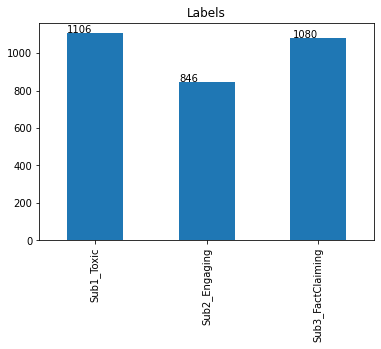

In [ ]:
ax = df[labels].sum(axis=0).plot(kind='bar', title='Labels');
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.001))

In [ ]:
df['categorized'] = df.iloc[:,1:].sum(axis=1).apply(bool)
df['categorized'].value_counts()

True     2130
False    1064
Name: categorized, dtype: int64

In [ ]:
categorized_rows = df[df['categorized'] == True]
uncategorized_rows = df[df['categorized'] == False].sample(frac=0.3)

In [ ]:
df = categorized_rows.append(uncategorized_rows)
df['categorized'].value_counts()

True     2130
False     319
Name: categorized, dtype: int64

###Baseline Model

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
german_stop_words = stopwords.words('german')

In [ ]:
re_stop_words = re.compile(r"\b(" + "|".join(german_stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
df['comment_text'] = df['comment_text'].apply(removeStopWords)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
MAX_VOCAB = 500

In [ ]:
encoder = layers.experimental.preprocessing.TextVectorization(
                    max_tokens=MAX_VOCAB, standardize='lower_and_strip_punctuation'
                )

In [ ]:
sequences = df["comment_text"].values

In [ ]:
targets = df[labels].values

In [ ]:
encoder.adapt(sequences)

In [ ]:
print(encoder.get_vocabulary()[:20])

['', '[UNK]', 'user', 'mal', 'mehr', 'ja', 'schon', 'immer', 'menschen', 'medium', 'afd', 'geht', 'deutschland', 'gibt', 'leben', 'wer', 'einfach', 'grünen', 'ganz', 'warum']


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(targets.shape[1], activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.CategoricalCrossentropy()])

In [ ]:
history = model.fit(sequences, targets, epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
62/62 [==============================] - 8s 74ms/step - loss: 0.6924 - categorical_crossentropy: 1.5766 - val_loss: 0.6913 - val_categorical_crossentropy: 0.4886
Epoch 2/10
62/62 [==============================] - 4s 56ms/step - loss: 0.6898 - categorical_crossentropy: 1.5722 - val_loss: 0.6902 - val_categorical_crossentropy: 0.4892
Epoch 3/10
62/62 [==============================] - 4s 57ms/step - loss: 0.6790 - categorical_crossentropy: 1.5835 - val_loss: 0.6961 - val_categorical_crossentropy: 0.5149
Epoch 4/10
62/62 [==============================] - 4s 58ms/step - loss: 0.6618 - categorical_crossentropy: 1.5804 - val_loss: 0.6760 - val_categorical_crossentropy: 0.5071
Epoch 5/10
62/62 [==============================] - 4s 58ms/step - loss: 0.6536 - categorical_crossentropy: 1.5653 - val_loss: 0.6582 - val_categorical_crossentropy: 0.5022
Epoch 6/10
62/62 [==============================] - 4s 59ms/step - loss: 0.6483 - categorical_crossentropy: 1.5597 - val_loss: 0.6495 -

In [ ]:
pred = model.predict(sequences)

In [ ]:
from sklearn.metrics import classification_report
THRESH = 0.5
for i in range(len(labels)):
    y_true = targets[:,i]
    y_pred = (pred[:,i] > THRESH).astype(int)
    print(f"======={labels[i]}")
    print(classification_report(y_true, y_pred))

=======Sub1_Toxic
              precision    recall  f1-score   support

           0       0.62      0.41      0.49      1343
           1       0.49      0.70      0.58      1106

    accuracy                           0.54      2449
   macro avg       0.56      0.55      0.54      2449
weighted avg       0.56      0.54      0.53      2449

=======Sub2_Engaging
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1603
           1       0.69      0.54      0.60       846

    accuracy                           0.76      2449
   macro avg       0.74      0.71      0.71      2449
weighted avg       0.75      0.76      0.75      2449

=======Sub3_FactClaiming
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1369
           1       0.65      0.59      0.62      1080

    accuracy                           0.68      2449
   macro avg       0.67      0.67      0.67      2449
weighted a

In [ ]:
from scipy import stats
y_pred = (pred > THRESH)

difference = tf.math.logical_xor(tf.cast(targets, dtype=bool), y_pred)
difference = difference.numpy().sum(axis=1)
print("difference stats :\n\t",stats.describe(difference))

difference stats :
	 DescribeResult(nobs=2449, minmax=(0, 3), mean=1.0265414454879542, variance=0.9196384011614717, skewness=0.4668549845355353, kurtosis=-0.8833186782206646)


In [ ]:
m = tf.keras.metrics.Recall()
m.update_state(targets, y_pred)
m.result().numpy()

0.61510557

In [ ]:
m = tf.keras.metrics.Precision()
m.update_state(targets, y_pred)
m.result().numpy()

0.58063513